In [1]:
import pandas as pd
import numpy as np

# scikit-learn core tools
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Just for nicer console output
def create_divider():
    print('-' * 100)


Section 1 — Load required tables (same base as RQ2, plus oversight tables)

In [2]:
pull_requests = pd.read_parquet(
    'hf://datasets/hao-li/AIDev/pull_request.parquet'
)

pr_commit_details = pd.read_parquet(
    'hf://datasets/hao-li/AIDev/pr_commit_details.parquet'
)

pr_reviews = pd.read_parquet(
    'hf://datasets/hao-li/AIDev/pr_reviews.parquet'
)

pr_comments = pd.read_parquet(
    'hf://datasets/hao-li/AIDev/pr_comments.parquet'
)

# Prefer v2 if it exists (it does in the current dataset)
try:
    pr_review_comments = pd.read_parquet(
        'hf://datasets/hao-li/AIDev/pr_review_comments_v2.parquet'
    )
    print('Loaded pr_review_comments_v2')
except Exception:
    pr_review_comments = pd.read_parquet(
        'hf://datasets/hao-li/AIDev/pr_review_comments.parquet'
    )
    print('Loaded pr_review_comments (non-v2)')

print('pull_requests shape:', pull_requests.shape)
create_divider()

print('pr_reviews shape:', pr_reviews.shape)
print('pr_comments shape:', pr_comments.shape)
print('pr_review_comments shape:', pr_review_comments.shape)
create_divider()


Loaded pr_review_comments_v2
pull_requests shape: (33596, 14)
----------------------------------------------------------------------------------------------------
pr_reviews shape: (28875, 7)
pr_comments shape: (39122, 7)
pr_review_comments shape: (26868, 15)
----------------------------------------------------------------------------------------------------


Section 2 — PR-level wrangling (same style as RQ2, plus time variables)

In [3]:
prs = pull_requests.copy()

# Keep naming consistent with RQ2
prs = prs.rename(columns={
    'id': 'pr_id',        # PR identifier
    'agent': 'agent_name' # AI agent
})

# Parse timestamps so duration math doesn’t silently break
for c in ['created_at', 'closed_at', 'merged_at']:
    prs[c] = pd.to_datetime(prs[c], errors='coerce')

# Merge flag: 1 if merged_at is not null, else 0
prs['merged_flag'] = prs['merged_at'].notna().astype(int)

# Time-to-merge (hours), only defined if merged
prs['time_to_merge_hours'] = np.where(
    prs['merged_flag'] == 1,
    (prs['merged_at'] - prs['created_at']).dt.total_seconds() / 3600,
    np.nan
)

print('=== PR-level columns (subset) ===')
print(prs[['pr_id', 'agent_name', 'state', 'created_at', 'merged_at', 'merged_flag']].head())
create_divider()

print('merged_flag value proportions:')
print(prs['merged_flag'].value_counts(normalize=True).round(3))
create_divider()


=== PR-level columns (subset) ===
        pr_id   agent_name   state                created_at  \
0  3264933329  Claude_Code  closed 2025-07-26 02:59:01+00:00   
1  3265118634  Claude_Code  closed 2025-07-26 04:56:55+00:00   
2  3265640341  Claude_Code  closed 2025-07-26 13:31:19+00:00   
3  3265709660  Claude_Code  closed 2025-07-26 14:07:22+00:00   
4  3265782173  Claude_Code    open 2025-07-26 15:02:48+00:00   

                  merged_at  merged_flag  
0                       NaT            0  
1 2025-07-26 22:12:24+00:00            1  
2 2025-07-26 13:37:22+00:00            1  
3 2025-07-26 14:45:30+00:00            1  
4                       NaT            0  
----------------------------------------------------------------------------------------------------
merged_flag value proportions:
merged_flag
1    0.715
0    0.285
Name: proportion, dtype: float64
----------------------------------------------------------------------------------------------------


Section 3 — Complexity features (this is literally your RQ2 block)

In [4]:
cd = pr_commit_details.copy()

print('=== commit_details sample ===')
print(cd.head())
create_divider()

complexity = (
    cd.groupby('pr_id')
      .agg(
          total_additions=('additions', 'sum'),
          total_deletions=('deletions', 'sum'),
          files_changed=('filename', 'nunique'),
          total_changes=('changes', 'sum'),
      )
      .reset_index()
)

print('=== Complexity features (per PR) ===')
print(complexity.head())
create_divider()

# Replace any remaining NaNs with 0 (safe for these counts)
complexity[['total_additions', 'total_deletions', 'files_changed', 'total_changes']] = (
    complexity[['total_additions', 'total_deletions', 'files_changed', 'total_changes']]
    .fillna(0)
)


=== commit_details sample ===
                                        sha       pr_id  \
0  2f9d54dda4f0c87c19e0bbeb9936f525d0587e16  3271196926   
1  2f9d54dda4f0c87c19e0bbeb9936f525d0587e16  3271196926   
2  2f9d54dda4f0c87c19e0bbeb9936f525d0587e16  3271196926   
3  dbd1b5f129f7cffa5ce284d7255814c98bcc38a2  3271196926   
4  c2659cfdedf666c8f14753d71664563c2a932b23  3271196926   

                      author                  committer  \
0  devin-ai-integration[bot]  devin-ai-integration[bot]   
1  devin-ai-integration[bot]  devin-ai-integration[bot]   
2  devin-ai-integration[bot]  devin-ai-integration[bot]   
3  devin-ai-integration[bot]  devin-ai-integration[bot]   
4  devin-ai-integration[bot]  devin-ai-integration[bot]   

                                             message  commit_stats_total  \
0  Add llms.txt compilation system for AI model d...               23008   
1  Add llms.txt compilation system for AI model d...               23008   
2  Add llms.txt compilation syst

Section 4 — Oversight features (RQ3 core wrangling)

In [5]:
# Reviews: per PR
rv = pr_reviews.copy()
rv['submitted_at'] = pd.to_datetime(rv['submitted_at'], errors='coerce')

reviews_agg = (
    rv.groupby('pr_id')
      .agg(
          n_reviews=('id', 'count'),
          n_reviewers=('user', 'nunique'),
          n_approvals=('state', lambda s: (s == 'APPROVED').sum()),
          n_changes_requested=('state', lambda s: (s == 'CHANGES_REQUESTED').sum()),
          first_review_time=('submitted_at', 'min'),
      )
      .reset_index()
)

print('=== reviews_agg sample ===')
print(reviews_agg.head())
create_divider()

# PR discussion comments: per PR
cm = pr_comments.copy()
cm['created_at'] = pd.to_datetime(cm['created_at'], errors='coerce')

comments_agg = (
    cm.groupby('pr_id')
      .agg(n_pr_comments=('id', 'count'))
      .reset_index()
)

print('=== comments_agg sample ===')
print(comments_agg.head())
create_divider()

# Inline review comments:
# review_comments.pull_request_review_id -> pr_reviews.id -> pr_id
rc = pr_review_comments.copy()
rc['created_at'] = pd.to_datetime(rc['created_at'], errors='coerce')

inline_map = rc[['id', 'pull_request_review_id']].merge(
    rv[['id', 'pr_id']].rename(columns={'id': 'pull_request_review_id'}),
    on='pull_request_review_id',
    how='left'
)

inline_agg = (
    inline_map.groupby('pr_id')
              .agg(n_inline_review_comments=('id', 'count'))
              .reset_index()
)

print('=== inline_agg sample ===')
print(inline_agg.head())
create_divider()


=== reviews_agg sample ===
        pr_id  n_reviews  n_reviewers  n_approvals  n_changes_requested  \
0  2756921963         30            1            0                    0   
1  2758636941          1            1            0                    1   
2  2759620798          1            1            1                    0   
3  2760115428          1            1            0                    1   
4  2760243902          1            1            1                    0   

          first_review_time  
0 2024-12-24 00:27:08+00:00  
1 2024-12-25 09:46:47+00:00  
2 2024-12-26 10:52:50+00:00  
3 2025-01-01 12:59:55+00:00  
4 2024-12-29 07:52:31+00:00  
----------------------------------------------------------------------------------------------------
=== comments_agg sample ===
        pr_id  n_pr_comments
0  2756921963              3
1  2757103560              5
2  2757124156              4
3  2757125491              4
4  2757179026              4
---------------------------------------

Section 5 — Build df_rq3 (merge PR + complexity + oversight) + basic cleaning

In [6]:
# Merge PR metadata with complexity features (same idea as RQ2)
df_rq3 = prs.merge(complexity, on='pr_id', how='inner')

# Add oversight tables
df_rq3 = df_rq3.merge(reviews_agg, on='pr_id', how='left')
df_rq3 = df_rq3.merge(comments_agg, on='pr_id', how='left')
df_rq3 = df_rq3.merge(inline_agg, on='pr_id', how='left')

print('df_rq3 shape:', df_rq3.shape)
create_divider()

# No oversight rows just means "no recorded review activity"
fill_zero_cols = [
    'n_reviews', 'n_reviewers', 'n_approvals', 'n_changes_requested',
    'n_pr_comments', 'n_inline_review_comments'
]
for c in fill_zero_cols:
    df_rq3[c] = df_rq3[c].fillna(0).astype(int)

# Time to first review (hours). If no reviews, leave as NaN for now.
df_rq3['time_to_first_review_hours'] = np.where(
    df_rq3['first_review_time'].notna(),
    (df_rq3['first_review_time'] - df_rq3['created_at']).dt.total_seconds() / 3600,
    np.nan
)

# Helpful indicator: whether any review happened at all
df_rq3['has_review'] = (df_rq3['n_reviews'] > 0).astype(int)

# If no review, time_to_first_review is undefined. Use -1 as a clean sentinel.
df_rq3['time_to_first_review_hours'] = df_rq3['time_to_first_review_hours'].fillna(-1)

# Log-transform complexity (same as RQ2)
df_rq3['log_total_changes'] = np.log1p(df_rq3['total_changes'])

# For “merge decision”, closed PRs are the cleanest slice
df_rq3 = df_rq3[df_rq3['state'] == 'closed'].copy()

# Drop rows missing in key columns we model on
df_rq3 = df_rq3.dropna(
    subset=['agent_name', 'merged_flag', 'log_total_changes', 'files_changed']
)

print('df_rq3 shape after cleaning:', df_rq3.shape)
create_divider()

print('merged_flag distribution (proportion):')
print(df_rq3['merged_flag'].value_counts(normalize=True).round(3))
create_divider()


df_rq3 shape: (33580, 27)
----------------------------------------------------------------------------------------------------
df_rq3 shape after cleaning: (31268, 30)
----------------------------------------------------------------------------------------------------
merged_flag distribution (proportion):
merged_flag
1    0.768
0    0.232
Name: proportion, dtype: float64
----------------------------------------------------------------------------------------------------


Section 6 — RQ3 descriptive summary (agent-level oversight + outcomes)

In [7]:
agent_summary_rq3 = (
    df_rq3.groupby('agent_name')
          .agg(
              n_prs=('pr_id', 'nunique'),
              merge_rate=('merged_flag', 'mean'),
              mean_log_changes=('log_total_changes', 'mean'),
              mean_files_changed=('files_changed', 'mean'),
              mean_reviews=('n_reviews', 'mean'),
              mean_reviewers=('n_reviewers', 'mean'),
              mean_pr_comments=('n_pr_comments', 'mean'),
              mean_inline_comments=('n_inline_review_comments', 'mean'),
              mean_t_first_review=('time_to_first_review_hours', 'mean'),
          )
          .sort_values('n_prs', ascending=False)
)

print('Agent-level summary for RQ3:')
print(agent_summary_rq3)
create_divider()


Agent-level summary for RQ3:
              n_prs  merge_rate  mean_log_changes  mean_files_changed  \
agent_name                                                              
OpenAI_Codex  20987    0.857864          4.357279           12.075666   
Devin          4668    0.555913          5.154384           25.222579   
Copilot        3888    0.550154          4.843459           24.362140   
Cursor         1346    0.746657          5.344828           16.710996   
Claude_Code     379    0.715040          6.347179           30.633245   

              mean_reviews  mean_reviewers  mean_pr_comments  \
agent_name                                                     
OpenAI_Codex      0.204698        0.144470          0.291323   
Devin             1.148886        0.620394          3.049486   
Copilot           3.412551        1.369342          2.917953   
Cursor            1.168648        0.716196          1.404160   
Claude_Code       1.311346        0.688654          1.788918   

          

Section 7 — Predictive modelling (Random Forest, same eval format as RQ2)

In [8]:
# Define feature and target columns (built on top of RQ2 features)
feature_num_cols = [
    'log_total_changes',
    'files_changed',
    'n_reviews',
    'n_reviewers',
    'n_approvals',
    'n_changes_requested',
    'n_pr_comments',
    'n_inline_review_comments',
    'time_to_first_review_hours',
    'has_review'
]
feature_cat_cols = ['agent_name']

# Make sure these exist (this catches typos early)
for column in feature_num_cols + feature_cat_cols + ['merged_flag']:
    assert column in df_rq3.columns, f'Missing column: {column}'

X = df_rq3[feature_num_cols + feature_cat_cols]
y = df_rq3['merged_flag']

x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f'Train size: {len(x_train)}, Test size: {len(x_test)}')
create_divider()

# Preprocess: impute numeric + one-hot agent_name
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, feature_num_cols),
        ('cat', categorical_transformer, feature_cat_cols),
    ]
)

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# 10-fold stratified cross-validation (ROC AUC), same style as RQ2
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_auc = cross_val_score(
    clf,
    X,
    y,
    cv=cv,
    scoring='roc_auc'
)

print(f'10-fold CV ROC AUC scores: {cv_auc}')
print(f'Mean CV AUC: {cv_auc.mean():.3f} +/- {cv_auc.std():.3f}')
create_divider()

# Fit and evaluate on test set
clf.fit(x_train, y_train)

y_pred_proba = clf.predict_proba(x_test)[:, 1]
y_pred = clf.predict(x_test)

test_auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

print('\n=== Test set performance (Random Forest) ===')
print('Test ROC AUC:', round(test_auc, 3))
print('\nConfusion matrix (rows=true, cols=pred):')
print(cm)
print('\nClassification report:')
print(classification_report(y_test, y_pred))
create_divider()

# Feature importance (RF)
rf_model = clf.named_steps['classifier']
ohe = clf.named_steps['preprocessor'].named_transformers_['cat']

numeric_names = feature_num_cols
cat_ohe_names = ohe.get_feature_names_out(feature_cat_cols).tolist()
all_feature_names = numeric_names + cat_ohe_names

importances = rf_model.feature_importances_

fi_df = (
    pd.DataFrame({'feature': all_feature_names, 'importance': importances})
      .sort_values('importance', ascending=False)
)

print('=== Top 25 RF feature importances ===')
print(fi_df.head(25))
create_divider()


Train size: 25014, Test size: 6254
----------------------------------------------------------------------------------------------------
10-fold CV ROC AUC scores: [0.75202797 0.76530297 0.7547432  0.74458473 0.77113526 0.73422636
 0.74462603 0.75192254 0.75197576 0.73539272]
Mean CV AUC: 0.751 +/- 0.011
----------------------------------------------------------------------------------------------------

=== Test set performance (Random Forest) ===
Test ROC AUC: 0.741

Confusion matrix (rows=true, cols=pred):
[[ 700  751]
 [ 574 4229]]

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.48      0.51      1451
           1       0.85      0.88      0.86      4803

    accuracy                           0.79      6254
   macro avg       0.70      0.68      0.69      6254
weighted avg       0.78      0.79      0.78      6254

----------------------------------------------------------------------------------------------------
=== Top

Section 8 — Final output: df_rq3_clean

In [9]:
df_rq3_clean = df_rq3.copy()

print('df_rq3_clean shape:', df_rq3_clean.shape)
print('df_rq3_clean columns:')
print(df_rq3_clean.columns.tolist())
create_divider()

print(df_rq3_clean.head())


df_rq3_clean shape: (31268, 30)
df_rq3_clean columns:
['pr_id', 'number', 'title', 'body', 'agent_name', 'user_id', 'user', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url', 'html_url', 'merged_flag', 'time_to_merge_hours', 'total_additions', 'total_deletions', 'files_changed', 'total_changes', 'n_reviews', 'n_reviewers', 'n_approvals', 'n_changes_requested', 'first_review_time', 'n_pr_comments', 'n_inline_review_comments', 'time_to_first_review_hours', 'has_review', 'log_total_changes']
----------------------------------------------------------------------------------------------------
         pr_id  number                                              title  \
0   3264933329    2911  Fix: Wait for all partitions in load_collectio...   
1   3265118634       2                   ファイルパス参照を相対パスに統一し、doc/からdocs/に統一   
2   3265640341      30        Add build staleness detection for debug CLI   
3   3265709660     205  feat: add comprehensive README screenshots wit...   

## RQ3 Visualizations

The plots below make the RQ3 story visible:
PR complexity → merge outcomes, oversight intensity → merge outcomes, and RF feature importances.

In [10]:
import matplotlib.pyplot as plt

# If this already exists earlier, redefining it is harmless.
def create_divider():
    print('-' * 100)


----------------------------------------------------------------------------------------------------
Graph 1: Merge rate vs PR size (log_total_changes bins)
----------------------------------------------------------------------------------------------------


C:\Users\yueya\AppData\Local\Temp\ipykernel_33436\1008539345.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df.groupby('size_bin')


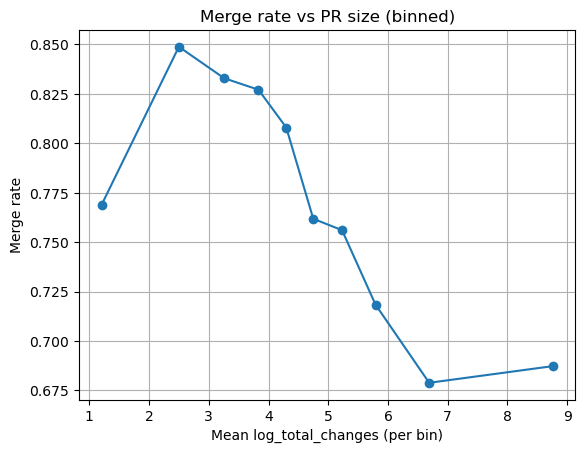

   n_prs  merge_rate  mean_log_changes
0   3558    0.768971          1.206505
1   2897    0.848809          2.498667
2   3004    0.832889          3.256847
3   3100    0.827097          3.830767
4   3161    0.807972          4.296248
5   3069    0.761812          4.748294
6   3115    0.756019          5.230704
7   3114    0.718369          5.790681
8   3123    0.678834          6.689337
9   3127    0.687240          8.755377


In [11]:
# ------------------------------
# Graph 1: Merge rate vs PR size
# ------------------------------
create_divider()
print('Graph 1: Merge rate vs PR size (log_total_changes bins)')
create_divider()

plot_df = df_rq3_clean.copy()

# Balanced bins (quantiles) so the curve isn't dominated by rare extremes
plot_df['size_bin'] = pd.qcut(plot_df['log_total_changes'], q=10, duplicates='drop')

size_summary = (
    plot_df.groupby('size_bin')
           .agg(
               n_prs=('pr_id', 'count'),
               merge_rate=('merged_flag', 'mean'),
               mean_log_changes=('log_total_changes', 'mean')
           )
           .reset_index()
)

plt.figure()
plt.plot(size_summary['mean_log_changes'], size_summary['merge_rate'], marker='o')
plt.xlabel('Mean log_total_changes (per bin)')
plt.ylabel('Merge rate')
plt.title('Merge rate vs PR size (binned)')
plt.grid(True)
plt.show()

print(size_summary[['n_prs', 'merge_rate', 'mean_log_changes']])


----------------------------------------------------------------------------------------------------
Graph 2: Merge rate vs oversight intensity (binned)
----------------------------------------------------------------------------------------------------


C:\Users\yueya\AppData\Local\Temp\ipykernel_33436\2871548787.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df.groupby('oversight_bin')


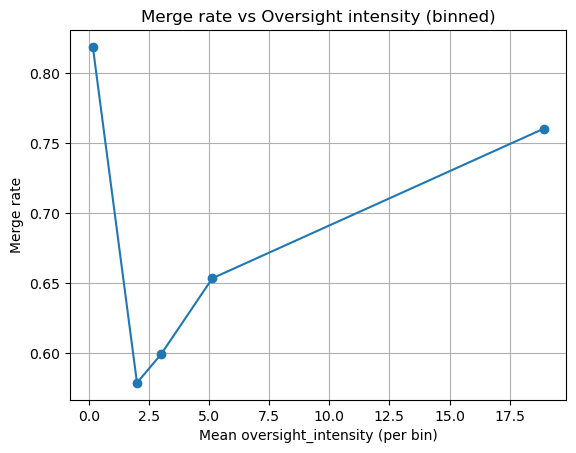

   n_prs  merge_rate  mean_oversight  mean_reviews  mean_comments
0  21501    0.818427        0.163109      0.033533       0.129575
1   2238    0.579088        2.000000      0.417784       1.509383
2   1857    0.599354        3.000000      0.674744       2.143242
3   2846    0.653549        5.137034      1.352776       3.106817
4   2826    0.760085       18.919321      6.453645       5.405520


In [12]:
# --------------------------------------
# Graph 2: Merge rate vs Oversight level
# --------------------------------------
create_divider()
print('Graph 2: Merge rate vs oversight intensity (binned)')
create_divider()

plot_df = df_rq3_clean.copy()

# Simple composite: total visible attention on the PR
plot_df['oversight_intensity'] = (
    plot_df['n_reviews'] +
    plot_df['n_pr_comments'] +
    plot_df['n_inline_review_comments']
)

# Quantile bins; duplicates dropped in case of many identical values (often lots of zeros)
plot_df['oversight_bin'] = pd.qcut(plot_df['oversight_intensity'], q=10, duplicates='drop')

ov_summary = (
    plot_df.groupby('oversight_bin')
           .agg(
               n_prs=('pr_id', 'count'),
               merge_rate=('merged_flag', 'mean'),
               mean_oversight=('oversight_intensity', 'mean'),
               mean_reviews=('n_reviews', 'mean'),
               mean_comments=('n_pr_comments', 'mean')
           )
           .reset_index()
)

plt.figure()
plt.plot(ov_summary['mean_oversight'], ov_summary['merge_rate'], marker='o')
plt.xlabel('Mean oversight_intensity (per bin)')
plt.ylabel('Merge rate')
plt.title('Merge rate vs Oversight intensity (binned)')
plt.grid(True)
plt.show()

print(ov_summary[['n_prs', 'merge_rate', 'mean_oversight', 'mean_reviews', 'mean_comments']])


----------------------------------------------------------------------------------------------------
Graph 3: Top feature importances (Random Forest)
----------------------------------------------------------------------------------------------------


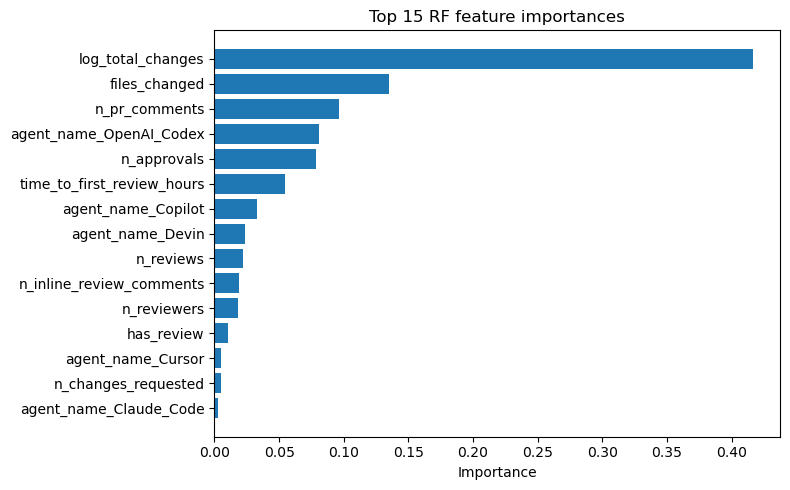

                       feature  importance
0            log_total_changes    0.416530
1                files_changed    0.134703
6                n_pr_comments    0.096378
14     agent_name_OpenAI_Codex    0.080451
4                  n_approvals    0.078868
8   time_to_first_review_hours    0.054752
11          agent_name_Copilot    0.032985
13            agent_name_Devin    0.023359
2                    n_reviews    0.022050
7     n_inline_review_comments    0.019206
3                  n_reviewers    0.018169
9                   has_review    0.010091
12           agent_name_Cursor    0.005308
5          n_changes_requested    0.004770
10      agent_name_Claude_Code    0.002379


In [13]:
# --------------------------------------
# Graph 3: Random Forest feature weights
# --------------------------------------
# This expects you to have already built `fi_df` in the modelling section.
create_divider()
print('Graph 3: Top feature importances (Random Forest)')
create_divider()

top_k = 15
top_fi = fi_df.head(top_k).copy()

plt.figure(figsize=(8, 5))
plt.barh(top_fi['feature'][::-1], top_fi['importance'][::-1])
plt.xlabel('Importance')
plt.title(f'Top {top_k} RF feature importances')
plt.tight_layout()
plt.show()

print(top_fi)


## Conclusion (RQ3)

The Random Forest model predicts merge outcomes with ROC AUC around ~0.74–0.75, which suggests there is real signal beyond chance. The strongest driver of merge success is PR complexity: `log_total_changes` and `files_changed` dominate feature importance, which matches the intuition that bigger changes are harder to review and integrate. Oversight features matter too—PR comments, approvals, and time-to-first-review add predictive value even after controlling for complexity. Agent identity also shows measurable differences in merge patterns, suggesting some agents produce PRs that are more merge-friendly than others under similar levels of oversight and complexity. These findings are associative rather than causal, but they give a clean, data-backed view of how complexity and human review dynamics relate to merge outcomes for agent-authored PRs.